In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#regression
from lightgbm import LGBMClassifier

## Acquire data

In [2]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
all_data_df = pd.concat([train_df,test_df])

/home/whale/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




## Analyze by describing data

### Distribution of sales

In [3]:
sales_df = train_df.copy(deep=True)
sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

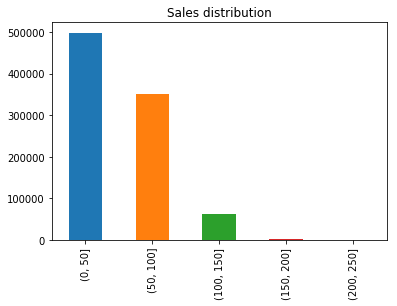

In [4]:
pd.value_counts(sales_df.sales_bins).plot(kind='bar', title='Sales distribution');

In [5]:
train_df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


### How does sales vary across stores

In [6]:
# Let us understand the sales data distribution across the stores
store_df = train_df.copy()
sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
# Pivoted dataframe
display(sales_pivoted_df)

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                     ...                 \
item          7          8          9          10    ...             41   
store                                                ...                  
1      52.783680  69.472070  46.504929  66.354326    ...      20.002738   
2      75.058598  99.090361  65.478094  94.097481    ...      28.069551   
3      66.647864  87.517525  58.486857  83.387733    ...      24.989047   
4      61.625411  80.819825  54.043812  77.047645    ...      23.168127   
5      44.535597  58.565717  38.837349  55.509858    ...      16.830778   
6      44.599124  58.385542  39.460022  55.565170    ...      16.607338   
7      40.709748  53.723987  35.901972  51.156627    ...      15.471522   
8      71.730559  94.461117  63.193319  89.818182    ...      27.036145   
9      61.812158  81.287514  54.105696  77.105148    ...      23.191128   
10     65.807777  86.176889  57.886637  82.232202    ...      24.654984   

                                                                          \
item          42         43         44          45         46         47   
store                                                                      
1      33.105696  46.242607  26.594195   72.720701  52.845016  19.814348   
2      47.368018  65.785323  37.785871  103.381161  75.219606  28.187842   
3      41.797371  58.197700  33.386090   91.851041  66.748083  25.120482   
4      38.539978  54.018620  30.952355   84.687295  61.420044  23.114458   
5      27.730559  39.163198  22.415115   61.427163  44.734940  16.699343   
6      27.893209  39.034502  22.322563   61.142935  44.539978  16.708653   
7      25.435926  35.426068  20.446331   55.905805  40.828587  15.479189   
8      45.144031  62.980285  36.194414   98.941402  72.004929  27.150055   
9      38.643483  54.152793  30.968237   85.093647  62.010953  23.003286   
10     41.222892  57.942497  32.916758   90.690581  66.046550  24.755750   

                                        
item          48         49         50  
store                                   
1      46.546002  26.461665  59.342826  
2      66.028478  37.711939  84.622125  
3      58.700986  33.259584  74.958379  
4      53.765608  30.840635  68.921687  
5      39.281490  22.371851  50.319277  
6      39.052574  22.181271  50.516429  
7      35.624315  20.406353  45.823658  
8      62.737130  36.035049  80.972070  
9      53.976999  31.052574  69.308324  
10     57.814896  33.032311  74.037240  

[10 rows x 50 columns]

In [7]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [8]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

### How does sales vary across items

In [9]:
# Let us calculate the average sales of each of the item across all the stores
sales_across_item_df = sales_pivoted_df.copy()
# Aggregate the sales per item and add it as a new row in the same dataframe
sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
#ПОЧЕМУ 11-Я СТРОКА?
# Note the 11th index row, which is the average sale of each of the item across all the storesdisplay(sales_across_item_df.loc[11:])
avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
avg_sales_per_item_across_stores_df.head(10)

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418
44,45,80.584173
37,38,80.521906
21,22,80.502245
35,36,77.028916
7,8,76.950055


In [10]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

### Time-series visualization of the sales

In [11]:
store_item_df = train_df.copy()
# First, let us filterout the required data
store_id = 10   # Some store
item_id = 40    # Some item
store_item_df = store_item_df[store_item_df.store == store_id]
store_item_df = store_item_df[store_item_df.item == item_id]

# Let us plot this now
store_item_ts_data = [go.Scatter(
    x=store_item_df.date,
    y=store_item_df.sales)]
py.iplot(store_item_ts_data)

In [12]:
multi_store_item_df = train_df.copy()
# First, let us filterout the required data
store_ids = [1, 1, 1, 1]   # Some stores
item_ids = [10, 20, 30, 40]    # Some items
print('Before filter:', multi_store_item_df.shape)
multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
print('After filter:', multi_store_item_df.shape)
#display(multi_store_item_df)
# TODO Monthly avg sales

# Let us plot this now
multi_store_item_ts_data = []
for st,it in zip(store_ids, item_ids):
    flt = multi_store_item_df[multi_store_item_df.store == st]
    flt = flt[flt.item == it]
    multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
py.iplot(multi_store_item_ts_data)

Before filter: (913000, 4)
After filter: (7304, 4)


## Datetime features

In [13]:
all_data_df['date'] = pd.to_datetime(all_data_df['date'],infer_datetime_format=True)
all_data_df['month'] = all_data_df['date'].dt.month
all_data_df['weekday'] = all_data_df['date'].dt.dayofweek
all_data_df['year'] = all_data_df['date'].dt.year

all_data_df['week_of_year']  = all_data_df.date.dt.weekofyear
#all_data_df['is_holiday'] = ???

In [14]:
all_data_df.head()

,date,id,item,sales,store,month,weekday,year,week_of_year
0,2013-01-01,NaN,1,13.0,1,1,1,2013,1
1,2013-01-02,NaN,1,11.0,1,1,2,2013,1
2,2013-01-03,NaN,1,14.0,1,1,3,2013,1
3,2013-01-04,NaN,1,13.0,1,1,4,2013,1
4,2013-01-05,NaN,1,10.0,1,1,5,2013,1


In [15]:
all_data_df['store_item_shifted-90'] = all_data_df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(90)) #3 months ago
all_data_df['store_item_shifted-122'] = all_data_df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(122)) #4 months ago
all_data_df['store_item_shifted-183'] = all_data_df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(180)) #6 months ago
all_data_df['store_item_shifted-245'] = all_data_df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(245)) #9 months ago
all_data_df['store_item_shifted-365'] = all_data_df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(365)) #1 year ago

In [16]:
print(all_data_df['sales'])
print(all_data_df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(1)))

0        13.0
1        11.0
2        14.0
3        13.0
4        10.0
5        12.0
6        10.0
7         9.0
8        12.0
9         9.0
10        9.0
11        7.0
12       10.0
13       12.0
14        5.0
15        7.0
16       16.0
17        7.0
18       18.0
19       15.0
20        8.0
21        7.0
22        9.0
23        8.0
24       14.0
25       12.0
26       12.0
27       11.0
28        6.0
29        9.0
         ... 
44970     NaN
44971     NaN
44972     NaN
44973     NaN
44974     NaN
44975     NaN
44976     NaN
44977     NaN
44978     NaN
44979     NaN
44980     NaN
44981     NaN
44982     NaN
44983     NaN
44984     NaN
44985     NaN
44986     NaN
44987     NaN
44988     NaN
44989     NaN
44990     NaN
44991     NaN
44992     NaN
44993     NaN
44994     NaN
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64
0         NaN
1        13.0
2        11.0
3        14.0
4        13.0
5        10.0
6        12.0
7   

In [17]:
#ПОЛЕЗНО ЛИ ЭТО НАДРАЧИВАНИЕ? ОСТАВИТЬ 4 ФИЧИ И ЧЕКНУТЬ
all_data_df["median-store_item-year"] = all_data_df.groupby(["year","item","store"])["sales"].transform("median")
all_data_df["median-store_item-month"] = all_data_df.groupby(["month","item","store"])["sales"].transform("median")
all_data_df["median-store_item-week"] = all_data_df.groupby(["week_of_year","item","store"])["sales"].transform("median")

all_data_df["mean-store_item-year"] = all_data_df.groupby(["year","item","store"])["sales"].transform("mean")
all_data_df["mean-store_item-month"] = all_data_df.groupby(["week_of_year","item","store"])["sales"].transform("mean")
all_data_df["mean-store_item-week"] = all_data_df.groupby(["week_of_year","item","store"])["sales"].transform("mean")

all_data_df["item-year-sum"] = all_data_df.groupby(["year","item"])["sales"].transform("sum")
all_data_df["item-month-sum"] = all_data_df.groupby(["month","item"])["sales"].transform("sum")

all_data_df["store-year-sum"] = all_data_df.groupby(["year","store"])["sales"].transform("sum")
all_data_df["store-month-sum"] = all_data_df.groupby(["month","store"])["sales"].transform("sum")

In [18]:
all_data_df.tail()

,date,id,item,sales,store,month,weekday,year,week_of_year,store_item_shifted-90,...,median-store_item-year,median-store_item-month,median-store_item-week,mean-store_item-year,mean-store_item-month,mean-store_item-week,item-year-sum,item-month-sum,store-year-sum,store-month-sum
44995,2018-03-27,44995.0,50,NaN,10,3,1,2018,13,63.0,...,NaN,67.0,68.0,NaN,68.771429,68.771429,0.0,92609.0,0.0,411975.0
44996,2018-03-28,44996.0,50,NaN,10,3,2,2018,13,59.0,...,NaN,67.0,68.0,NaN,68.771429,68.771429,0.0,92609.0,0.0,411975.0
44997,2018-03-29,44997.0,50,NaN,10,3,3,2018,13,74.0,...,NaN,67.0,68.0,NaN,68.771429,68.771429,0.0,92609.0,0.0,411975.0
44998,2018-03-30,44998.0,50,NaN,10,3,4,2018,13,62.0,...,NaN,67.0,68.0,NaN,68.771429,68.771429,0.0,92609.0,0.0,411975.0
44999,2018-03-31,44999.0,50,NaN,10,3,5,2018,13,82.0,...,NaN,67.0,68.0,NaN,68.771429,68.771429,0.0,92609.0,0.0,411975.0


### Split data for modelling

In [19]:
col = [i for i in all_data_df.columns if i not in ['date','id']]
y = 'sales'

In [20]:
train_df.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

## Evaluation should use temporal train test split or temporal CV

In [21]:
# Можно забить недостающие элементы нулями и попробовать random forest
# Можно попробовать lgb вместо xgb

### Missing data

In [22]:
all_data_na = (all_data_df.isnull().sum() / len(all_data_df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(40)

,Missing Ratio
id,95.302714
store_item_shifted-365,19.050104
store_item_shifted-245,12.787056
store_item_shifted-183,9.394572
store_item_shifted-122,6.367432
mean-store_item-year,4.697286
median-store_item-year,4.697286
store_item_shifted-90,4.697286
sales,4.697286


In [23]:
all_data_df.drop(['id'], axis=1, inplace=True)

In [24]:
all_data_df = all_data_df.fillna(-1000)

In [25]:
print("old train",train_df.shape)
train_df = all_data_df.loc[~all_data_df.sales.isna()]
print("new train",train_df.shape)
test_df = all_data_df.loc[all_data_df.sales.isna()]

old train (913000, 4)
new train (958000, 23)


In [26]:
train_x, train_cv, y, y_cv = train_test_split(train_df[col],train_df[y], test_size=0.15, random_state=42)

### Random Forest

In [27]:
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(train_x, y)
acc_random_forest = round(random_forest.score(train_cv, y_cv) * 100, 2)
acc_random_forest

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
y_test = random_forest.predict(train_df)
sample['sales'] = y_test
sample.to_csv('simple_starter.csv', index=False)